In [1]:
# Fordham University
# Felipe Trinidad Pilier
# April 6, 2024

In [2]:
import pandas as pd
import numpy as np

# Read the Data Set
# CSV file must be in the same folder as this ipynb file
df = pd.read_csv("sms-spam-dataset.csv", encoding='ISO-8859-1', header='infer')

In [3]:
import pandas as pd
import re
# Remove punctuation and extra spaces
df['Text'] = df['Text'].str.lower().str.replace('[^\w\s]', '')

# Print Class Values
class_counts = df['Class'].value_counts()
print(class_counts)

Class
ham     4825
spam     747
Name: count, dtype: int64


In [4]:
# Change ham to 0 and spam to 1
class_mapping = {'ham':0, 'spam':1}

df['Class'] = df['Class'].map(class_mapping)

# Set axis
X_data = df['Text']
y_data = df['Class']

In [5]:
# function for displaying top 20 features

def show_top_features_informative(algorithm_name, vectorizer_type, vectorizer, classifier, n=20):
    feature_names = vectorizer.get_feature_names_out()
    top_features_ham = np.argsort(classifier.feature_log_prob_[0])[-n:][::-1]
    top_features_spam = np.argsort(classifier.feature_log_prob_[1])[-n:][::-1]

    print(f"{algorithm_name} with {vectorizer_type} Vectorization - Top {n} Features")
    print(f"Spam: [{', '.join(feature_names[feature] for feature in top_features_spam)}]")
    print(f"Ham: [{', '.join(feature_names[feature] for feature in top_features_ham)}]\n")


In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
 
def evaluate_model(X, y, vectorizer='count', vectorizer_params={}, model=MultinomialNB()):
 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
 
    if vectorizer == 'count':
        vectorizer_obj = CountVectorizer(**vectorizer_params)
    elif vectorizer == 'tfidf':
        vectorizer_obj = TfidfVectorizer(**vectorizer_params)
    else:
        raise ValueError("The vectorizer argument must be 'count' or 'tfidf'.")
 
    clf_pipeline = Pipeline([
        ('vectorizer', vectorizer_obj),
        ('classifier', model)
    ])
 
    clf_pipeline.fit(X_train, y_train)
    y_train_pred = clf_pipeline.predict(X_train)
    y_test_pred = clf_pipeline.predict(X_test)
 
    num_features = len(clf_pipeline.named_steps['vectorizer'].get_feature_names_out())
    print(f"Number of features used: {num_features}")
    
    if isinstance(model, (MultinomialNB, ComplementNB)):
        vectorizer_step = clf_pipeline.named_steps['vectorizer']
        classifier_step = clf_pipeline.named_steps['classifier']
        algorithm_name = type(classifier_step).__name__  
        vectorizer_type = 'TF-IDF' if isinstance(vectorizer_step, TfidfVectorizer) else 'Count'
        show_top_features_informative(algorithm_name, vectorizer_type, vectorizer_step, classifier_step)
    
 
    train_metrics = {
        'accuracy': accuracy_score(y_train, y_train_pred),
        'f1': f1_score(y_train, y_train_pred),
        'precision': precision_score(y_train, y_train_pred),
        'recall': recall_score(y_train, y_train_pred),
        'confusion_matrix': confusion_matrix(y_train, y_train_pred).tolist(),
    }
 
    test_metrics = {
        'accuracy': accuracy_score(y_test, y_test_pred),
        'f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'confusion_matrix': confusion_matrix(y_test, y_test_pred).tolist(),
    }
 
    if hasattr(clf_pipeline, "predict_proba"):
        test_metrics['auc'] = roc_auc_score(y_test, clf_pipeline.predict_proba(X_test)[:, 1])
        train_metrics['auc'] = roc_auc_score(y_train, clf_pipeline.predict_proba(X_train)[:, 1])
    
    # All calculated metrics will be stored in performance
    performance = {
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'num_features': num_features
    }  
    return performance

In [7]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
import pandas as pd

def generate_model_configurations(models, vectorizer_params):
    model_configurations = []
    for model in models:
        for params in vectorizer_params:
            model_configurations.append({'vectorizer_params': params, 'model': model})
    return model_configurations

# Define common vectorizer parameters
vectorizer_params = [
    {'ngram_range': (1, 1), 'min_df': 1, 'lowercase': True, 'max_features': 500},
    {'ngram_range': (1, 2), 'min_df': 2, 'lowercase': False, 'max_features': 500},
    {'ngram_range': (1, 3), 'min_df': 3, 'lowercase': False, 'max_features': 500, 'stop_words': 'english'}
]

# Define models
models = [MultinomialNB(), ComplementNB(), SVC(probability=True)]

# Generate model configurations
model_configurations = generate_model_configurations(models, vectorizer_params)

# Initialize the results DataFrame
all_results = pd.DataFrame()

In [8]:
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
 
for config in model_configurations:
    # Evaluate the model with CountVectorizer
    performance_count = evaluate_model(
        X_data, y_data, 'count', config['vectorizer_params'], config['model']
    )
    # Create a DataFrame for count vectorizer performance for both training and testing
    train_df_count = pd.DataFrame([performance_count['train_metrics']])
    test_df_count = pd.DataFrame([performance_count['test_metrics']])


    # Add additional details to both DataFrames
    for df, data_type in zip([train_df_count, test_df_count], ['Training', 'Testing']):
        df['Data'] = data_type
        df['Vect_Type'] = 'count'
        df['Algorithm'] = type(config['model']).__name__
        df['ngram_range'] = str(config['vectorizer_params']['ngram_range'])
        df['min_df'] = config['vectorizer_params']['min_df']
        df['lowercase'] = config['vectorizer_params'].get('lowercase', 'Not Specified')
        df['num_features'] = performance_count['num_features']
    
    all_results = pd.concat([all_results, train_df_count, test_df_count], ignore_index=True)


    performance_tfidf = evaluate_model(
        X_data, y_data, 'tfidf', config['vectorizer_params'], config['model']
    )
    train_df_tfidf = pd.DataFrame([performance_tfidf['train_metrics']])
    test_df_tfidf = pd.DataFrame([performance_tfidf['test_metrics']])

    for df, data_type in zip([train_df_tfidf, test_df_tfidf], ['Training', 'Testing']):
        df['Data'] = data_type
        df['Vect_Type'] = 'tfidf'
        df['Algorithm'] = type(config['model']).__name__
        df['ngram_range'] = str(config['vectorizer_params']['ngram_range'])
        df['min_df'] = config['vectorizer_params']['min_df']
        df['lowercase'] = config['vectorizer_params'].get('lowercase', 'Not Specified')
        df['num_features'] = performance_count['num_features']
        
        all_results = pd.concat([all_results, train_df_tfidf, test_df_tfidf], ignore_index=True)

Number of features used: 500
MultinomialNB with Count Vectorization - Top 20 Features
Spam: [to, call, you, your, free, for, the, now, or, txt, is, ur, stop, on, text, from, have, mobile, and, claim]
Ham: [you, to, the, in, and, me, my, is, it, of, that, for, im, have, but, so, your, are, not, do]

Number of features used: 500
MultinomialNB with TF-IDF Vectorization - Top 20 Features
Spam: [to, call, free, your, txt, now, or, for, you, stop, text, mobile, ur, from, claim, the, www, is, reply, on]
Ham: [you, to, the, in, me, and, my, is, it, im, that, ok, of, are, for, have, not, so, at, can]

Number of features used: 500
MultinomialNB with Count Vectorization - Top 20 Features
Spam: [to, call, you, your, free, for, the, now, or, txt, is, ur, stop, on, text, from, have, mobile, and, claim]
Ham: [you, to, the, in, and, me, my, is, it, of, that, for, im, have, but, so, your, are, not, do]

Number of features used: 500
MultinomialNB with TF-IDF Vectorization - Top 20 Features
Spam: [to, ca

In [9]:
from IPython.display import display

column_order = [
    'Algorithm', 'Vect_Type', 'Data', 'ngram_range', 'min_df', 'lowercase', 
    'num_features', 'accuracy', 'f1', 'precision', 'recall', 'auc', 'confusion_matrix'
]

all_results = all_results[column_order]
display(all_results)

,Algorithm,Vect_Type,Data,ngram_range,min_df,lowercase,num_features,accuracy,f1,precision,recall,auc,confusion_matrix
0,MultinomialNB,count,Training,"(1, 1)",1.0,True,500.0,0.979182,0.921551,0.914132,0.929091,0.981795,"[[3581, 48], [39, 511]]"
1,MultinomialNB,count,Testing,"(1, 1)",1.0,True,500.0,0.981335,0.933673,0.938462,0.928934,0.987068,"[[1184, 12], [14, 183]]"
2,MultinomialNB,tfidf,Training,"(1, 1)",1.0,True,500.0,0.977028,0.906433,0.976891,0.845455,0.988942,"[[3618, 11], [85, 465]]"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966978,0.871508,0.968944,0.791878,0.991673,"[[1191, 5], [41, 156]]"
4,MultinomialNB,tfidf,Training,"(1, 1)",1.0,True,500.0,0.977028,0.906433,0.976891,0.845455,0.988942,"[[3618, 11], [85, 465]]"
5,MultinomialNB,tfidf,Testing,"(1, 1)",1.0,True,500.0,0.966978,0.871508,0.968944,0.791878,0.991673,"[[1191, 5], [41, 156]]"
6,MultinomialNB,count,Training,"(1, 2)",2.0,False,500.0,0.978703,0.920036,0.909414,0.930909,0.982061,"[[3578, 51], [38, 512]]"
7,MultinomialNB,count,Testing,"(1, 2)",2.0,False,500.0,0.979182,0.925450,0.937500,0.913706,0.983048,"[[1184, 12], [17, 180]]"
8,MultinomialNB,tfidf,Training,"(1, 2)",2.0,False,500.0,0.979421,0.916667,0.981328,0.860000,0.988168,"[[3620, 9], [77, 473]]"
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970567,0.887052,0.969880,0.817259,0.989237,"[[1191, 5], [36, 161]]"


In [10]:
def display_top_metrics(df, metric_name):
   
    top_row = df.nlargest(1, metric_name)
    print(f"Top {metric_name.capitalize()} Result:")
    print(f"Value: {top_row[metric_name].values[0]}")
    print("Other Metrics:")
    for column in df.columns:
        if column != metric_name:
            print(f"{column}: {top_row[column].values[0]}")
    print("----------------------------------------------------")

# Print top accuracy, auc, and f1 and other metrics
display_top_metrics(all_results, 'accuracy')
display_top_metrics(all_results, 'auc')
display_top_metrics(all_results, 'f1')

Top Accuracy Result:
Value: 0.9940177075855468
Other Metrics:
Algorithm: SVC
Vect_Type: tfidf
Data: Training
ngram_range: (1, 1)
min_df: 1.0
lowercase: True
num_features: 500.0
f1: 0.9767441860465117
precision: 1.0
recall: 0.9545454545454546
auc: 0.9996447806808787
confusion_matrix: [[3629, 0], [25, 525]]
----------------------------------------------------
Top Auc Result:
Value: 0.999654550464691
Other Metrics:
Algorithm: SVC
Vect_Type: tfidf
Data: Training
ngram_range: (1, 2)
min_df: 2.0
lowercase: False
num_features: 500.0
accuracy: 0.9940177075855468
f1: 0.9767873723305478
precision: 0.9981024667931688
recall: 0.9563636363636364
confusion_matrix: [[3628, 1], [24, 526]]
----------------------------------------------------
Top F1 Result:
Value: 0.9767873723305478
Other Metrics:
Algorithm: SVC
Vect_Type: tfidf
Data: Training
ngram_range: (1, 2)
min_df: 2.0
lowercase: False
num_features: 500.0
accuracy: 0.9940177075855468
precision: 0.9981024667931688
recall: 0.9563636363636364
auc: 0.

In [11]:
# Oversampling
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Load the CSV file into a DataFrame
data = pd.read_csv('sms-spam-dataset.csv', encoding='latin-1', header='infer')

# Split features (messages) and labels (spam/ham)
X = data['Text']
y = data['Class']

# Apply Random Oversampling to balance the classes
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X.values.reshape(-1, 1), y)

# Convert the resampled data back to a DataFrame
balanced_data = pd.DataFrame({'Text': X_resampled.flatten(), 'Class': y_resampled})

# Save the balanced DataFrame back to a CSV file
balanced_data.to_csv('balanced_data.csv', index=False)

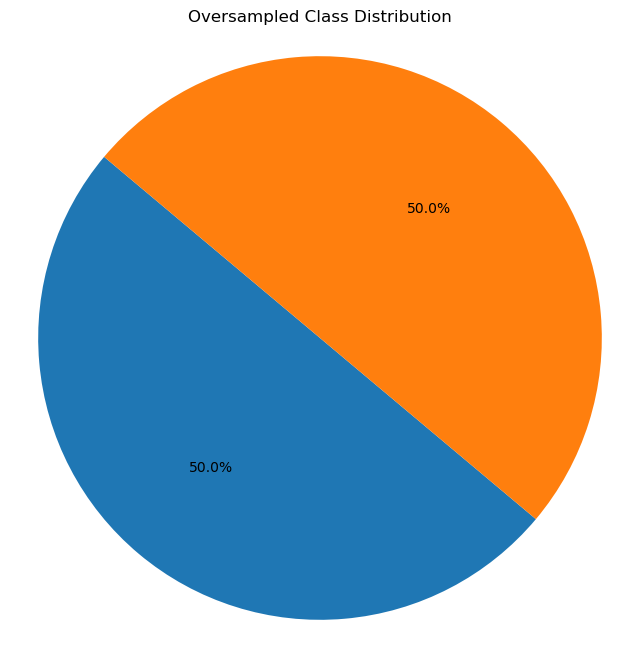

Class
ham     4825
spam    4825
Name: count, dtype: int64


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Plot oversampling through a pie chart

# Read oversampled CSV
df = pd.read_csv('balanced_data.csv')

# Check class distribution
class_distribution = df['Class'].value_counts()

# Display Balanced Classes in a pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, autopct='%1.1f%%', startangle=140)
plt.title('Oversampled Class Distribution')
plt.axis('equal')
plt.show()

# Print Classes
class_distribution = df['Class'].value_counts()
print(class_distribution)

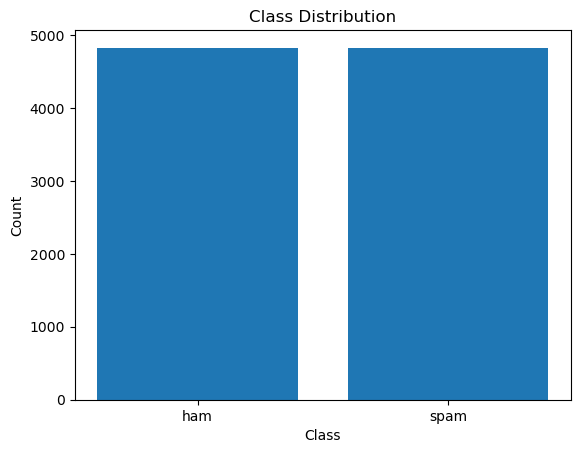

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Read the data from the CSV file
data = pd.read_csv('balanced_data.csv')  # Replace 'your_data.csv' with the path to your CSV file

# Step 2: Count the occurrences of each class
class_counts = data['Class'].value_counts()  # Replace 'class_column_name' with the name of your class column

# Step 3: Plot the data
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

class_distribution = df['Class'].value_counts()
print(class_distribution)